# 색상 히스토그램(비주얼) 기반으로 Shot 나누기

- Non-Linear Consumption of Videos Using a Sequence of Personalized Multimodal Fragments (IUI 21) 메서드 참고

- opencv gpu 세팅해야 시간이 빨라짐. cpu로 하면 시간이 많이 걸림

In [1]:
import utils
import cv2

# 원하는 비디오 URL 넣기
cap = utils.openVideoStream('https://www.youtube.com/watch?v=39O_N9llFno')
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# shot_boundary_detection 실행이 끝나면 비디오 스트림이 닫힘
# 여러 파라미터 조정해가며 해보기, bins는 16 정도면 충분한 것으로 보임
shots1, diffs1 = utils.shot_boundary_detection(cap, scale_factor=5, bins = 16, resize_dim=(640, 360))

'https://www.youtube.com/watch?v=39O_N9llFno'에서 30fps 비디오 스트림 URL을 가져오는 중...
🎥 선택된 해상도: 1080p @ 30fps, URL: https://rr7---sn-n3cgv5qc5oq-bh2z7.googlevideo.com/videoplayback?expire=1752244920&ei=WM5waLn3I-C4vcAP4KfKgA8&ip=163.180.118.139&id=o-AP9bgl6CieZWa58X3q9ZdEtN7PZo7YxDwgmJ_2Rs5OYZ&itag=137&aitags=133%2C134%2C135%2C136%2C137%2C160%2C242%2C243%2C244%2C247%2C248%2C278%2C394%2C395%2C396%2C397%2C398%2C399&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1752223320%2C&mh=O1&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2z7%2Csn-3pm7dn7y&ms=au%2Conr&mv=m&mvi=7&pcm2cms=yes&pl=20&rms=au%2Cau&gcr=kr&initcwndbps=4306250&siu=1&bui=AY1jyLN83keB-fmgDrIU6hXZXzuRmuUGGOs5jBtgCQJfNi5phse31QBWG6EwjkychYCGExxwZA&vprv=1&svpuc=1&mime=video%2Fmp4&ns=GM65rNvNfVtqeVl3QejSKYIQ&rqh=1&gir=yes&clen=21017767&dur=240.640&lmt=1735967149633253&mt=1752223038&fvip=5&keepalive=yes&lmw=1&fexp=51476175&c=TVHTML5&sefc=1&txp=4432434&n=UB-s9OgVob1KFQ&sparams=expire%2Cei%2Cip%2Cid%2Caitags%2Csource%2Crequiressl%2Cxpc%2Cgcr%2Csiu%2

프레임 처리 중: 100%|██████████| 7211/7211 [02:00<00:00, 60.05it/s, 프레임=7211, 차이=0.0065, 임계값=0.0149, 샷 경계=X] 


샷 경계 감지 완료. 총 42개의 샷 경계 감지됨.


In [2]:
shots1 = utils.sum_short_boundaries(shots1)
len(shots1)

42

c:\Users\KHU\Desktop\Research\autospeed\utils.py:679: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 레이아웃 자동 조정
c:\Users\KHU\Desktop\Research\autospeed\utils.py:679: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 레이아웃 자동 조정
c:\Users\KHU\Desktop\Research\autospeed\utils.py:679: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 레이아웃 자동 조정
c:\Users\KHU\anaconda3\envs\pytch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KHU\anaconda3\envs\pytch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KHU\anaconda3\envs\pytch\lib\site-packages\IPython

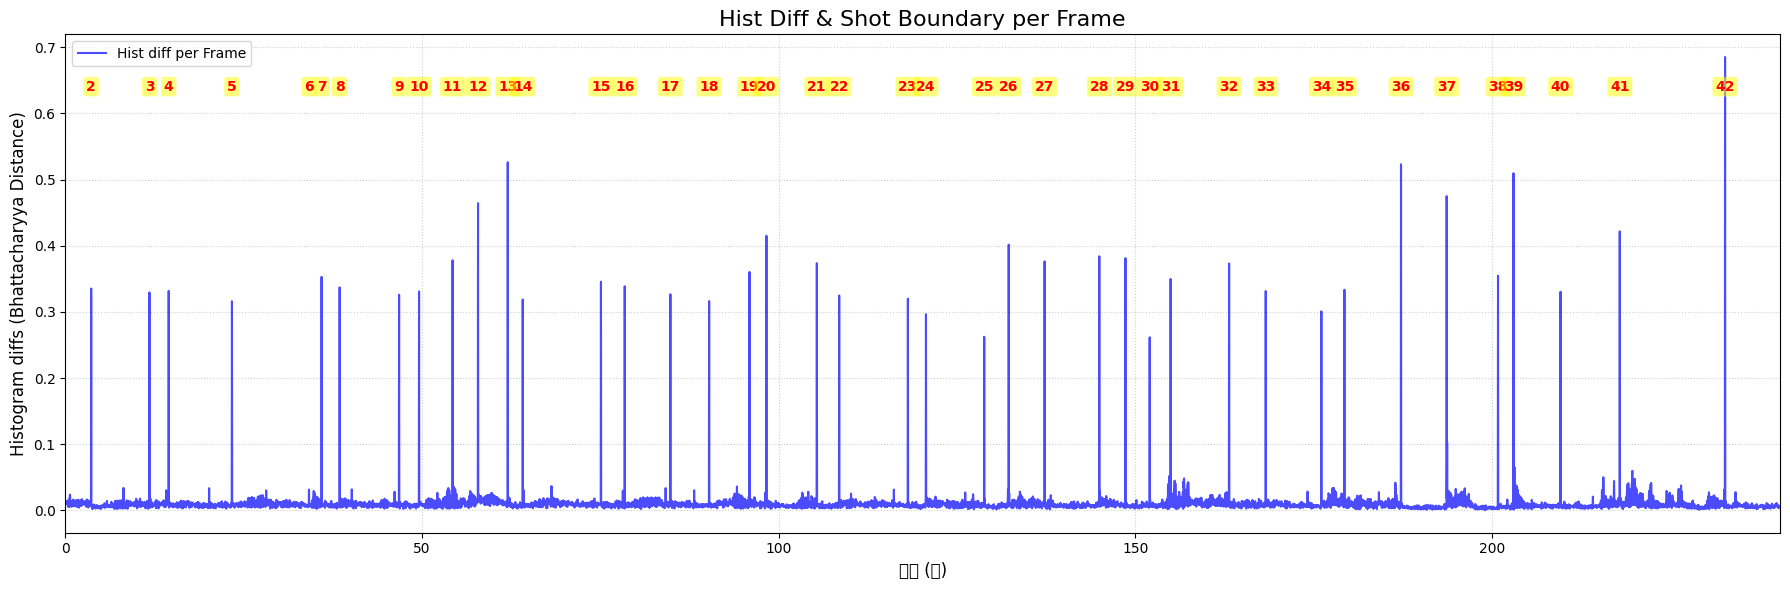

In [4]:
utils.visualize_shot_detection(diffs1, shots1, 30, total_frames)

In [5]:
import cv2
import numpy as np
from tqdm import tqdm

def save_with_shot_labels_720p(cap: cv2.VideoCapture, shot_boundaries, output_path="output.mp4", fps=30):
    """
    cap으로부터 전체 영상을 읽고, 샷 경계마다 "SHOT: n" 텍스트를 추가하여 720p로 저장
    """
    orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"🎞️ 원본 해상도: {orig_width}x{orig_height}, 총 프레임: {total_frames}")

    # 리사이즈 여부 판단 (720p 기준)
    if orig_height > 720:
        scale_ratio = 720 / orig_height
        new_width = int(orig_width * scale_ratio)
        new_height = 720
        print(f"⚠️ 해상도가 높아 720p로 리사이즈: {new_width}x{new_height}")
    else:
        new_width = orig_width
        new_height = orig_height
        print(f"✅ 리사이즈 없이 저장: {new_width}x{new_height}")

    # 출력 비디오 설정
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))

    # Shot 경계 처리용 세팅
    shot_boundaries_set = set(shot_boundaries)
    current_shot_idx = 1
    current_shot_text = f"SHOT: {current_shot_idx}"
    current_shot_color = np.random.randint(0, 256, 3).tolist()

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_thickness = 3

    with tqdm(total=total_frames, desc="💾 저장 중", unit="frame") as pbar:
        for frame_idx in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break

            # 새로운 샷이면 텍스트, 색상 갱신
            if frame_idx > 0 and frame_idx in shot_boundaries_set:
                current_shot_idx += 1
                current_shot_text = f"SHOT: {current_shot_idx}"
                current_shot_color = np.random.randint(0, 256, 3).tolist()

            # 텍스트 위치 계산
            (text_width, text_height), baseline = cv2.getTextSize(
                current_shot_text, font, font_scale, font_thickness
            )
            text_x = (orig_width - text_width) // 2
            text_y = text_height + 20

            # 텍스트 추가
            cv2.putText(
                frame,
                current_shot_text,
                (text_x, text_y),
                font,
                font_scale,
                current_shot_color,
                font_thickness,
                cv2.LINE_AA,
            )

            # 리사이즈 필요 시
            if (orig_width, orig_height) != (new_width, new_height):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)

            out.write(frame)
            pbar.update(1)

    cap.release()
    out.release()
    print(f"✅ 저장 완료: {output_path}")


In [6]:
cap = utils.openVideoStream('https://www.youtube.com/watch?v=39O_N9llFno')
save_with_shot_labels_720p(cap, shots1, output_path="output_shots.mp4", fps=30)

'https://www.youtube.com/watch?v=39O_N9llFno'에서 30fps 비디오 스트림 URL을 가져오는 중...
🎥 선택된 해상도: 1080p @ 30fps, URL: https://rr7---sn-n3cgv5qc5oq-bh2z7.googlevideo.com/videoplayback?expire=1752243581&ei=HclwaMHXOL-CvcAP8dibsQg&ip=163.180.118.139&id=o-AGkrj6SN8VZUEpg2daMrGzgNW47iv1GxlFJ1rmEAk7Pa&itag=137&aitags=133%2C134%2C135%2C136%2C137%2C160%2C242%2C243%2C244%2C247%2C248%2C278%2C394%2C395%2C396%2C397%2C398%2C399&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1752221981%2C&mh=O1&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2z7%2Csn-ogueln66&ms=au%2Conr&mv=m&mvi=7&pcm2cms=yes&pl=20&rms=au%2Cau&gcr=kr&initcwndbps=4358750&siu=1&bui=AY1jyLPu5HdYtXE_YCS8wLHiUM72WAlPU5KPe-jMrCWQFysWGF0NC1T7nhZgC3y41pHx3fNjTg&vprv=1&svpuc=1&mime=video%2Fmp4&ns=Kyqmhb6JeLoPlysa0kYoJV4Q&rqh=1&gir=yes&clen=21017767&dur=240.640&lmt=1735967149633253&mt=1752221599&fvip=1&keepalive=yes&lmw=1&fexp=51476175&c=TVHTML5&sefc=1&txp=4432434&n=_B52OMef3aQoLg&sparams=expire%2Cei%2Cip%2Cid%2Caitags%2Csource%2Crequiressl%2Cxpc%2Cgcr%2Csiu%2

💾 저장 중: 100%|██████████| 7212/7212 [02:01<00:00, 59.22frame/s]

✅ 저장 완료: output_shots.mp4


In [3]:
import subprocess

def mux_audio_with_video(video_path: str, audio_path: str, output_path: str):
    """
    무음 영상과 오디오를 합쳐서 하나의 mp4 파일로 저장
    :param video_path: 영상 파일 경로 (예: output.mp4)
    :param audio_path: 오디오 파일 경로 (예: audio.wav)
    :param output_path: 최종 출력 파일 경로 (예: final.mp4)
    """
    command = [
        "ffmpeg", "-y",
        "-i", video_path,
        "-i", audio_path,
        "-c:v", "copy",            # 영상은 다시 인코딩하지 않고 복사
        "-c:a", "aac",             # 오디오는 aac로 인코딩
        "-strict", "experimental",
        "-shortest",               # 영상/오디오 길이 중 짧은 쪽에 맞춤
        output_path
    ]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print(f"✅ 최종 영상 생성 완료: {output_path}")


In [ ]:
import soundfile as sf
audio, sr = utils.getAudioCroppedFromURL('https://www.youtube.com/watch?v=39O_N9llFno')
sf.write("audio.wav", audio.squeeze(), sr)

mux_audio_with_video("output_shots.mp4", "audio.wav", "final_with_audio_color_hist.mp4")

✅ 최종 영상 생성 완료: final_with_audio.mp4                      
